# Convolutional neural network framework

In [108]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pandas as pd
sns.set_style("darkgrid")



# Keras documentation can be found on keras.io:
import keras
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Jens csv kode

In [109]:
def import_and_pad_csvs(folder_path):
    # List all CSV files in the given folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files_sorted = np.sort(np.array(csv_files))
    #print(csv_files_sorted)
    # Initialize an empty list to store the data arrays
    data_arrays = []

    indecies = np.zeros_like(csv_files_sorted, dtype=int)
    for i in range(len(csv_files_sorted)):
        indecies[i] = int(csv_files_sorted[i][:-6])
        #print(type(indecies[i]))
    #print(csv_files_sorted, indecies)
        
    
    # Iterate over the CSV files and read them into numpy arrays
    for file in csv_files_sorted:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path).values
        data_arrays.append(data)
    
    # Find the maximum number of rows and columns among all CSV files
    max_rows = max(array.shape[0] for array in data_arrays)
    max_cols = max(array.shape[1] for array in data_arrays)
    
    # Find the index of the largest array (by number of elements)
    largest_array_index = max(range(len(data_arrays)), key=lambda i: data_arrays[i].shape[0] * data_arrays[i].shape[1])
    
    print(f"Index of the largest initial array: {largest_array_index}")
    
    # Initialize a list to store padded arrays
    padded_arrays = np.zeros((max_rows, max_cols))
    center = max(int(max_rows / 2), int(max_cols / 2))
    max_size = 64
    combined_array = np.zeros((len(data_arrays), max_size, max_size))
    # Pad each array with zeros to match the maximum size
    nr = 0
    for array in data_arrays:
        #print(array.shape)
        #print(center - int(np.floor(array.shape[0] / 2)), center + int(np.ceil(array.shape[1] / 2)))
        padded_array = np.zeros((max_rows, max_cols)) + 4000
        #print(padded_array[center - int(np.floor(array.shape[0] / 2)) :center + int(np.ceil(array.shape[0]/2)),
                     #center - int(np.floor(array.shape[1] / 2)) :center + int(np.ceil(array.shape[1]/2))])
        padded_array[center - int(np.floor(array.shape[0] / 2)) :center + int(np.ceil(array.shape[0]/2)),
                     center - int(np.floor(array.shape[1] / 2)) :center + int(np.ceil(array.shape[1]/2))] = array
        combined_array[nr] = padded_array[center - int(max_size/2): center + int(max_size/2), center - int(max_size/2): center + int(max_size/2)]
        #combined_array = np.concatenate((combined_array, np.array([padded_arrays])), axis=0)
        #padded_arrays.append(padded_array)
        nr += 1
    

    # Stack all padded arrays along a new dimension to create the final array
    #combined_array = np.stack(padded_arrays, axis=0)
    
    
    return combined_array, indecies

# Import Data

In [110]:
a = np.array(['123456', '12345', '1235312'])



In [111]:
data_raw, index = import_and_pad_csvs('clusters_colour_rotations/')
labels_raw = [np.load('./labels/'+x) for x in os.listdir('./labels/') if x.endswith('.npy')]
print(len(labels_raw[8][0]), len(labels_raw[8][1]))

#labels_raw_sorted = np.sort(np.array(labels_raw))
label = []
ind = []
for value in labels_raw:
    label.append(value[1].tolist())
    ind.append(value[0].tolist())
    #print(len(value[1].tolist()), len(value[0].tolist()))
label = [item for sublist in label for item in sublist]
ind = [item for sublist in ind for item in sublist]
ind_sort_arg = np.argsort(np.repeat(ind, 8))
#mask = [index != ind]
#print(print(index, ind))
#plt.plot(index - ind)
#plt.show()

#index_remove = np.array([31, 74, 116, 165, 170, 193, 214, 280, 314, 401, 413, 470, 499])
#label = np.delete(label, index_remove)

label = np.repeat(label, 8)
#print(len(label)*8)
#print(data_raw.shape)


label_sorted = label[ind_sort_arg]

# Remove all reading erros, multiple objects, and others.
data_raw = data_raw[(label_sorted != 4) & (label_sorted != 0)]
label_sorted = label_sorted[(label_sorted != 4) & (label_sorted != 0)] - 1

#print(data_raw.shape)
# the data, split between train and testval sets
train_images, testval_images, train_labels, testval_labels = train_test_split(data_raw, label_sorted, test_size=0.3, random_state=13052020)

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(testval_images, testval_labels, test_size=0.2, random_state=13052020)



Index of the largest initial array: 3929
31 31


# Normelize Data

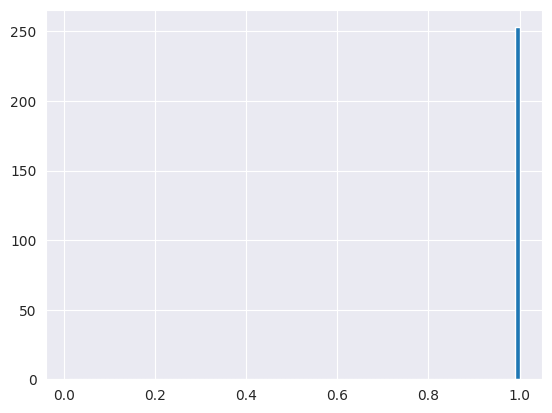

In [112]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, RobustScaler

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)


#scaler = MinMaxScaler()
#scaler = QuantileTransformer()
scaler = RobustScaler()
#sorted_images = np.sort(train_images.reshape(-1, 1))
#scaler.fit(sorted_images)
scaler.fit(train_images.reshape(-1, 1))
train_images = scaler.transform(train_images.reshape(-1, 1)).reshape(train_images.shape)
val_images = scaler.transform(val_images.reshape(-1, 1)).reshape(val_images.shape)

plt.hist(train_images.flatten(), bins=100, range=(0.01, 1))
plt.show()
# Standardize pixel distribution to have zero mean and unit variance
#train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
#val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))
# Alternative: quantile normalization
# train_images = quantile_transform(train_images, output_distribution='normal', copy=True)
# val_images = quantile_transform(val_images, output_distribution='normal', copy=True)




# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 64, 64 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 3 # number of classes
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
# test_images = quantile_transform(test_images, output_distribution='normal', copy=True)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# Setup CNN

In [113]:
def compile_CNN_model(model_type=Sequential(), layer_types=[Conv2D, MaxPooling2D, Flatten, Dropout, Dense], hyperperams_list=np.zeros((7,3)), img_rows=28, img_cols=28, num_classes=10):
    model = model_type  # Network model type

    N_layers = len(layer_types)
    layers = np.array([])
    for i in range(layer_types):
        if layer_types[i] == 0:
            layers = np.append(layers, Conv2D)
            hyp_peram = {'filters': hyperperams_list[i, 0], 'kernel_size': hyperperams_list[i, 1], 'strides': hyperperams_list[i, 2], 'activation': 'relu', 'input_shape': (img_rows, img_cols, 1)}
            hyperperams = np.append(hyperperams, hyp_peram)

        if layer_types[i] == 1:
            layers = np.append(layers, MaxPooling2D)
            hyp_peram = {'pool_size': hyperperams_list[i, 0], 'strides': hyperperams_list[i, 1]}
            hyperperams = np.append(hyperperams, hyp_peram)
        if layer_types[i] == 2:
            layers = np.append(layers, Flatten)
            hyp_peram = {}
            hyperperams = np.append(hyperperams, hyp_peram)
        if layer_types[i] == 3:
            layers = np.append(layers, Dropout)
            hyp_peram = {'rate': hyperperams_list[i, 0]}
            hyperperams = np.append(hyperperams, hyp_peram)

        if layer_types[i] == 4:
            layers = np.append(layers, Dense)
            hyp_peram = {'units': hyperperams_list[i, 0], 'activation': 'relu'}
            
    
    for i in range(N_layers):
        model.add(layers[i](**layer_hyperperams[i]))

    
    # specify optimization strategy and metric used for monitoring during training
    model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

    return model



model = Sequential()  # Network type is Sequential

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

/home/sk0rt3/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,483 (8.07 MB)

 Trainable params: 2,116,483 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

# Train CNN

In [114]:
# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=256,
                    epochs=100,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - categorical_accuracy: 0.2591 - loss: 161.3145 - val_categorical_accuracy: 0.2106 - val_loss: 109.1379
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - categorical_accuracy: 0.2677 - loss: 146.7508 - val_categorical_accuracy: 0.2291 - val_loss: 99.2579
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - categorical_accuracy: 0.2901 - loss: 136.8194 - val_categorical_accuracy: 0.2556 - val_loss: 91.0016
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - categorical_accuracy: 0.2955 - loss: 127.0667 - val_categorical_accuracy: 0.2927 - val_loss: 83.8409
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - categorical_accuracy: 0.3229 - loss: 120.7425 - val_categorical_accuracy: 0.3179 - val_loss: 77.9708
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - categorical_accuracy: 0.3323 - loss: 119.0967 - val_categorical_accuracy: 0.3364 - val_loss: 72.6828
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - categorical_accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.50016767 0.12039484 0.3794375 ]]


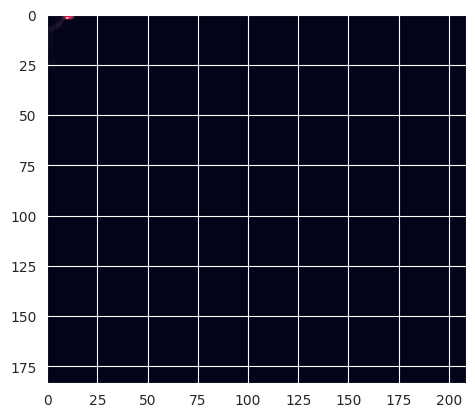

In [144]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.show()

# Hyperperameter optimization

In [ ]:
import optuna


def objective(trial):
    layer_numbers = trial.suggest_int('layer_numbers', 1, 10)
    peram = {'model_type': Sequential(),
                'layer_types': [trail.sugeest_int('layer_types', 0, 4, layer_numbers) for i in range(layer_numbers)],
                'hyperperams_list': np.zeros((7,3)),
                'img_rows': 28,
                'img_cols': 28,
                'num_classes': 10
                }
        
    

def objective_exmaple(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1),
        'objective': 'binary:logistic'
    }
    bst = XGBClassifier(**param)
    bst.fit(df_train_X_clf_final, df_train_Y_clf_final)
    preds = bst.predict_proba(df_valid_X_clf_final)
    log_log_clf_XGB = log_loss(df_valid_Y_clf_final, preds)
    return log_log_clf_XGB

study_example = optuna.create_study(direction='minimize')
study_example.optimize(objective_example, n_trials=20, show_progress_bar=True)